In [21]:
#imports
import math
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax.example_libraries import stax
from jax.example_libraries import optimizers
import random as rd
import pickle
import os

In [22]:
#METODA AUTOGRAD

#Definicja Lagrangianu dla pojedynńczego wachadła liczonego w sposób analityczny
#Argumenty funkcji:
#  -q   - położenie ciała
#  -q_t - prędkość ciała
#  -m   - masa ciała
#  -l   - długość liny
#  -g   - wartość przyśpieszenia ziemskiego
#Zwracane: wartość Lagrangianu w danym momencie.
def lagrangian_analitical(q, q_t, m, l, g):
    #Eneriga kinetyczna
    Ek=0.5*m*l*jnp.square(q_t)
    
    #Energia potencjalna
    Ep=m*g*(l-l*jnp.cos(q))
    
    #Lagrangian
    return jnp.sum(Ek - Ep)

#Obliczenie energi potencjalnej i kinetycznej układu na podstawie aktualnego stanu
#Argumenty funkcji:
#  -q   - położenie ciała
#  -q_t - prędkość ciała
#  -m   - masa ciała
#  -l   - długość liny
#  -g   - wartość przyśpieszenia ziemskiego
#Zwracane: 
#  -Ek  - Energia kinetyczna
#  -Ep  - Energia potencjalna
def compute_energy(q, q_t, m, l, g):
    #Eneriga kinetyczna
    Ek=0.5*m*l*jnp.square(q_t)
    
    #Energia potencjalna
    Ep=m*g*(l-l*jnp.cos(q))
    
    #Lagrangian
    return Ek, Ep

#Funkcja ma za zadanie reprezenotwanie równania różniczkowego, wynikającego z rozwiązania
#równanie Eulera-Lagrange'a
#Argumenty funkcji:
#   -lagrangian - Funkcja opisująca Lagrangian. Funkcja musi być typu ,,callable'' żeby,
#                 pochodne Lagrangianu zostały policzone.
#   -state      - Wektor zawierający wartości początkowe położenia i prędkości
#   -empty      - Aby ta funkcja mogła zostać poprawnie wywoływana w dalszej części programu
#                 koniecznym było dodanie ,,pustego'' argumentu, które nie będzie pełnił żadnej
#                 funkcji, ale pozwoli na poprawną kompilację
#Zwracane: Wektor zawiercający przyśpieszenia oraz prędkości w danym momencie.
def equation_of_motion(lagrangian, state, empty=None):
    #Rozdzilenie danych startowych na położenia i prędkości
    q, q_t = jnp.split(state, 2)
    
    #Obliczanie przyśpieszenia na podstawie lagrangianu
    q_tt = jax.numpy.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t)) @ (
		jax.grad(lagrangian, 0)(q, q_t)
		- jax.jacfwd(jax.grad(lagrangian, 1), 0)(q, q_t) @ q_t)
    return jnp.concatenate([q_t, q_tt])

#Funkcja wyznaczająca trajektorię ruchu przy użyciu Lagrangianu wyznaczonego
#w sposób analityczny
#Argumenty funkcji:
#   -initial_state - Początkowego położenie oraz prędkości
#   -times         - Czas wyznaczanej trajektori
#   -m             - masa wachadła
#   -l             - długość liny wachadła
#   -g             - przyśpieszenie ziemskie
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m=1, l=1, g=9.8):
  lagrangian = partial(lagrangian_analitical, m=m, l=l, g=g)
  equation = partial(equation_of_motion, lagrangian)
  return odeint(equation, initial_state, times, rtol=1e-10, atol=1e-10)

In [23]:
#METODA ANALICTYCZNA

#Funkcja obliczająca przyśpieszenie wahadła na podstawie aktualnego położenia i prędkości.
#Argumenty funkcji:
#   -initial_state - Początkowego położenie oraz prędkości
#   -empty         - Aby ta funkcja mogła zostać poprawnie wywoływana w dalszej części programu
#                   koniecznym było dodanie ,,pustego'' argumentu, które nie będzie pełnił żadnej
#                   funkcji, ale pozwoli na poprawną kompilację
#   -l             - długość liny wachadła
#   -g             - przyśpieszenie ziemskie
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
def analitical(initial_state, empty=None, l=1, g=9.8):
    q = initial_state[0]
    q_t = initial_state[1]
    q_tt = -g / l * jnp.sin(q)
    return jnp.concatenate((jnp.expand_dims(q_t, axis=0), jnp.expand_dims(q_tt, axis=0)), axis=0)

#Funkcja wyznaczająca trajektorię ruchu obliczoną przy użyciu analitycznie wyznaczonego 
# równiania różniczkowego (funkcja analitical)
#Argumenty funkcji:
#   -initial_state - Początkowego położenie oraz prędkości
#   -times         - Czas wyznaczanej trajektori
#   -l             - długość liny wachadła
#   -g             - przyśpieszenie ziemskie
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
@partial(jax.jit, backend='cpu')
def solve_analitical(initial_state, times, l=1, g=9.8):
    function = partial(analitical, l=l, g=g)
    return odeint(function, initial_state, t=times, rtol=1e-10, atol=1e-10)

In [24]:
#WYZNACZENIE PUNKTU STARTOWEGO, SZUMU, ORAZ CZASU DLA TESTU POWYŻSZYCH METOD WYZNACZANIA TRAJEKTORI

#Punkt startowy
x0 = jnp.array([0.5,0.2], dtype=np.float32)
#Szum
noise = np.random.RandomState(0).randn(x0.size)
#Wektor czasów
t = np.linspace(0, 40, num=401, dtype=np.float32)

In [25]:
#WYZNACZENIE TRAJEKTORI METODĄ AUTOGRAD ORAZ ANALITYCZNĄ

#Autograd
%time autograd_clean = jax.device_get(solve_autograd(x0, t))
#Autograd z małym szumem
%time autograd_noise1 = jax.device_get(solve_autograd(x0 + 1e-10*noise, t))
#Autograd z dużym szumem
%time autograd_noise2 = jax.device_get(solve_autograd(x0 + 1e-2*noise, t))

#Analitycznie
%time analitical_clean = jax.device_get(solve_analitical(x0, t))
#Analitycznie z małym szumem
%time analitical_noise1 = jax.device_get(solve_analitical(x0 + 1e-10*noise, t))
#Analitycznie z dużym szumem
%time analitical_noise2 = jax.device_get(solve_analitical(x0 + 1e-2*noise, t))

CPU times: user 660 ms, sys: 41.7 ms, total: 702 ms
Wall time: 701 ms
CPU times: user 3.01 ms, sys: 731 µs, total: 3.75 ms
Wall time: 2.57 ms
CPU times: user 2.23 ms, sys: 542 µs, total: 2.78 ms
Wall time: 2.26 ms
CPU times: user 300 ms, sys: 19.6 ms, total: 320 ms
Wall time: 316 ms
CPU times: user 2.39 ms, sys: 578 µs, total: 2.97 ms
Wall time: 3.39 ms
CPU times: user 1.65 ms, sys: 400 µs, total: 2.05 ms
Wall time: 1.78 ms


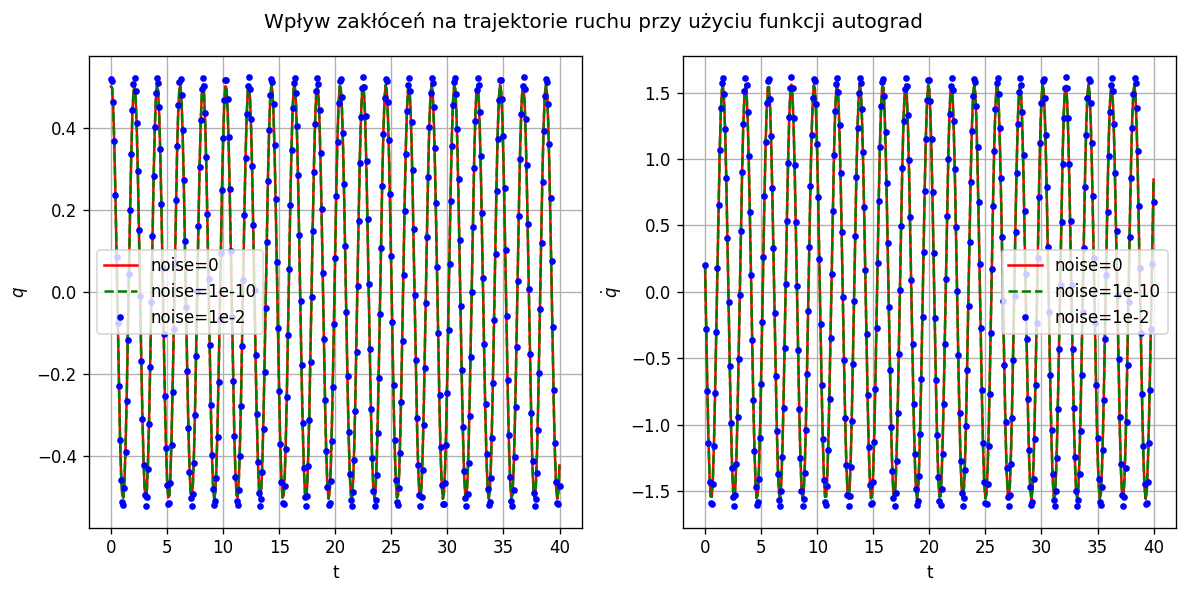

In [26]:
#WYŚWIETLENIE TRAJEKTORI (AUTOGRAD)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)

fig.suptitle("Wpływ zakłóceń na trajektorie ruchu przy użyciu funkcji autograd")

#Położenie (kąt)
axes[0].plot(t, autograd_clean[:, 0], 'r', label='noise=0')
axes[0].plot(t, autograd_noise1[:, 0], 'g--', label='noise=1e-10')
axes[0].plot(t, autograd_noise2[:, 0], 'b.', label='noise=1e-2')
axes[0].set_xlabel('t')
axes[0].set_ylabel('$q$')
axes[0].legend()
axes[0].grid()

#Prędkość (kątowa)
axes[1].plot(t, autograd_clean[:, 1], 'r', label='noise=0')
axes[1].plot(t, autograd_noise1[:, 1], 'g--', label='noise=1e-10')
axes[1].plot(t, autograd_noise2[:, 1], 'b.', label='noise=1e-2')
axes[1].set_xlabel('t')
axes[1].set_ylabel('$\dot q$')
axes[1].legend()
axes[1].grid()

plt.tight_layout()






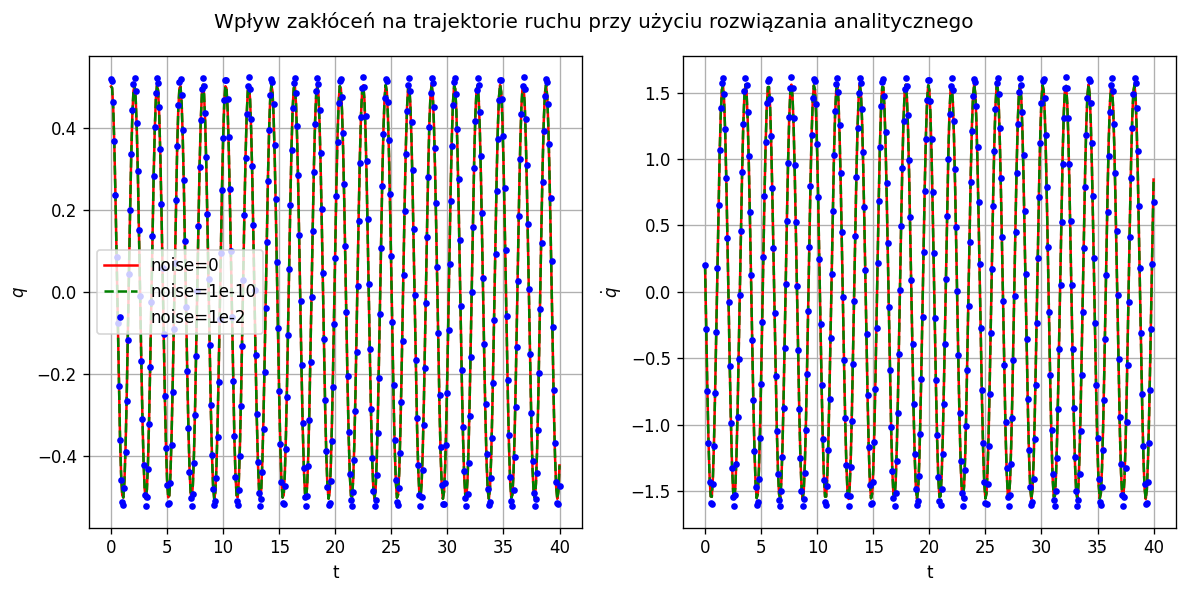

In [27]:
#WYŚWIETLENIE TRAJEKTORI (METODA ANALITYCZNA)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Wpływ zakłóceń na trajektorie ruchu przy użyciu rozwiązania analitycznego')

#Położenie (kąt)
axes[0].plot(t, analitical_clean[:, 0], 'r', label='noise=0')
axes[0].plot(t, analitical_noise1[:, 0], 'g--', label='noise=1e-10')
axes[0].plot(t, analitical_noise2[:, 0], 'b.', label='noise=1e-2')
axes[0].set_xlabel('t')
axes[0].set_ylabel('$q$')
axes[0].legend()
axes[0].grid()

#Prędkość (kątowa)
axes[1].plot(t, analitical_clean[:, 1], 'r', label='noise=0')
axes[1].plot(t, analitical_noise1[:, 1], 'g--', label='noise=1e-10')
axes[1].plot(t, analitical_noise2[:, 1], 'b.', label='noise=1e-2')
axes[1].set_xlabel('t')
axes[1].set_ylabel('$\dot q$')
axes[1].grid()

plt.tight_layout()

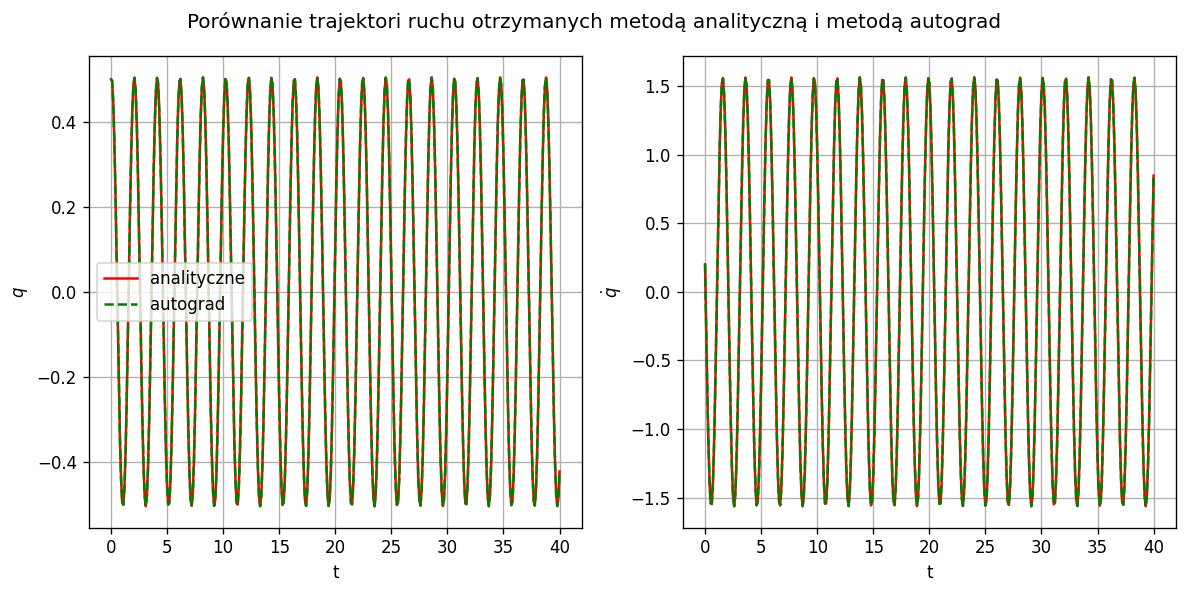

In [28]:
#PORÓWNANIE TRAJEKTORI OTRZYMANYCH PRZY UŻYCIU OBU METOD

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Porównanie trajektori ruchu otrzymanych metodą analityczną i metodą autograd')


#Położenie (kąt)
axes[0].plot(t, analitical_clean[:, 0], 'r', label='analityczne')
axes[0].plot(t, autograd_clean[:, 0], 'g--', label='autograd')
axes[0].set_xlabel('t')
axes[0].set_ylabel('$q$')
axes[0].legend()
axes[0].grid()

#Prędkość (kątowa)
axes[1].plot(t, analitical_clean[:, 1], 'r', label='analityczne')
axes[1].plot(t, autograd_clean[:, 1], 'g--', label='autograd')
axes[1].set_xlabel('t')
axes[1].set_ylabel('$\dot q$')
axes[1].grid()


plt.tight_layout()

In [29]:
#Funkcja normalizująca wektor stanu (położenie i prędkość). W przypadku położenia wartości 
#normalizowane są do zakresów <-Pi;Pi>. W przypadku prędkości wartości pozostają bez zmian.
#Argumenty:
#   state - wektor stanu [położenie, prędkość].
#Zwraca:
#   Unormowany wektor stanu.
def normalize(state):
    dim = int(len(state)/2)
    return jnp.concatenate([(state[:dim] + np.pi) % (2 * np.pi) - np.pi, state[dim:]])

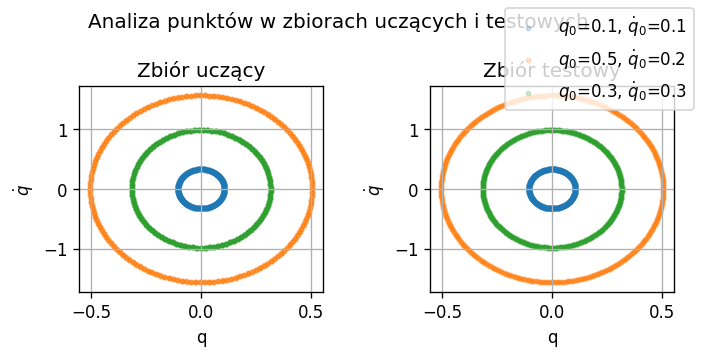

In [30]:
#BUDOWA ZBIORU UCZĄCEGO NA PODSTAWIE TRAJEKTORI WACHADŁA
N=1000

#Wektor punktów początkowych (3 warianty do testu)
x0 = jnp.array([[0.1,0.1], [0.5,0.2], [0.3, 0.3]], dtype=np.float32)

#Wektor czasów dla zbioru uczącego
t_train = np.arange(0,N, dtype=np.float32)
#Wektor czasów dla zbioru testowego
t_test = np.arange(N,2*N, dtype=np.float32)


fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120)

#Wyznaczenie 3 różnych zbiorów uczących na podstawie trajektori
#o różnych punktach startowych.
for i in range(x0.shape[0]):

    #Zbiór uczący
    x_train = jax.device_get(solve_analitical(x0[i], t_train))  #Dane wejściowe zbudowane na podstawie trajektori
    x_train = jax.device_get(jax.vmap(normalize)(x_train))      #Normalizacja danych wejściowych
    y_train = jax.device_get(jax.vmap(analitical)(x_train))     #Wyznaczenie danych wyjściowych (przyśpieszenie dla danych wektorów stanu [położenie, prędkość])

    #Zbiór testowy
    x_test = jax.device_get(solve_analitical(x_train[-1], t_train)) #Dane wejściowe zbudowane na podstawie trajektori
    x_test = jax.device_get(jax.vmap(normalize)(x_test))            #Normalizacja danych wejściowych
    y_test = jax.device_get(jax.vmap(analitical)(x_test))           #Wyznaczenie danych wyjściowych (przyśpieszenie dla danych wektorów stanu [położenie, prędkość])

    #Wyświetlenie wartość wejściowych na wykresie
    axes[0].scatter(x_train[:, 0], x_train[:, 1], s=6, alpha=0.2)
    axes[1].scatter(x_test[:, 0], x_test[:, 1], s=6, alpha=0.2)


#Wykres
fig.suptitle("Analiza punktów w zbiorach uczących i testowych")
axes[0].set_xlabel('q')
axes[0].set_ylabel('$\dot q$')
axes[0].set_title('Zbiór uczący')
axes[0].grid()
axes[1].set_xlabel('q')
axes[1].set_ylabel('$\dot q$')
axes[1].set_title('Zbiór testowy')
axes[1].grid()
fig.legend(['$q_0$=0.1, $\dot q_0$=0.1','$q_0$=0.5, $\dot q_0$=0.2', '$q_0$=0.3, $\dot q_0$=0.3'])
plt.tight_layout()



In [31]:
#BUDOWA ZBIORU UCZĄCEGO I TESTOWEGO NA PODSTAWIE WARTOŚCI LOSOWYCH

N=1000  #Liczność zbioru testowego i uczącego

#Maksymalne wartości prędkości w zbiorze
v_max=2*np.sqrt(9.81)

x_test_train = np.zeros([2*N, 2])
#Wyznaczenie losowych wartości położenia i prędkości 
x_test_train[:,0] = np.random.rand(N*2)*2*np.pi - np.pi  #Zakres wartości położenia <-Pi;Pi>
x_test_train[:,1] = np.random.rand(N*2)*2*v_max - v_max  #Zakres wartości <-Vmax;Vmax>
#Obliczenie wartości wyjściowych (przyśpieszenia) dla otrzymanych losowych punktów położenia i prędkości
#przy użyciu równania różniczkowego otrzymanego w sposób analityczny 
y_test_train = jax.device_get(jax.vmap(analitical)(x_test_train))

#Rozbicie zbioru na uczący i testowy
x_train = x_test_train[0:N]
y_train = y_test_train[0:N]

x_test = x_test_train[N:2*N]
y_test = y_test_train[N:2*N]

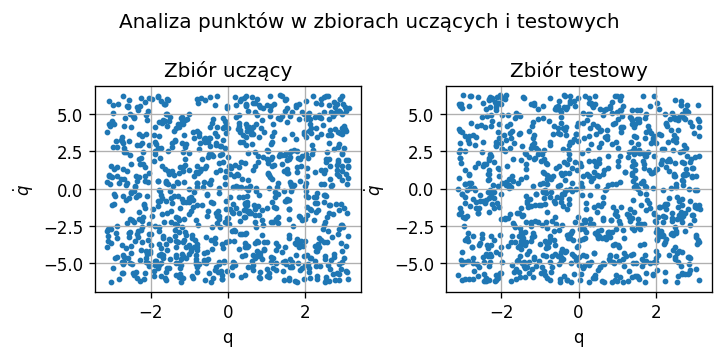

In [32]:
#WIZUALIZACJA ZBIORU DANYCH

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120)
fig.suptitle("Analiza punktów w zbiorach uczących i testowych")
axes[0].scatter(x_train[:, 0], x_train[:, 1], s=6)
axes[0].set_xlabel('q')
axes[0].set_ylabel('$\dot q$')
axes[0].set_title('Zbiór uczący')
axes[0].grid()
axes[1].scatter(x_test[:, 0], x_test[:, 1], s=6)
axes[1].set_xlabel('q')
axes[1].set_ylabel('$\dot q$')
axes[1].set_title('Zbiór testowy')
axes[1].grid()
plt.tight_layout()

In [33]:
#ARCHITEKUTRA SIECI NEURONOWEJ
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(64),
    stax.Softplus,
    stax.Dense(64),
    stax.Softplus,
    stax.Dense(1),
)

#Funkcja modelująca lagrangian (wyjście sieci neuronowej)
#Argumenty:
#   params - parametry sieci neuronowej
#   q, q_t - wektor wartości wejściowych dla sieci (położenie, przyśpieszenie)
#Zwraca:
#   lagrangian - wartość lagrangianu dla danego wektora stanu
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (1,)
    state = normalize(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian


#DEFINICJA BŁĘDU DLA SIECI
#Argumenty:
#   params  - parametry sieci neuronowej
#   state   - wektor stanu [położenie, prędkość]
#   target  - oczekiwany wektor wyjściowy sieci [prędkość, przyśpieszenie]
@partial(jax.jit, backend='cpu')
def MSE_loss(params, state, targets):
  preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean((preds[:,1] - targets[:,1]) ** 2)


def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

In [34]:
%%time
#UCZENIE SIECI NEURONOWEJ



Training=True       #Uczenie sieci
Epochs=2000       #Maksymalna liczba epok
StopError=0.01      #Wartość błędu MSE dla zbioru testowego, przy której uczenie zostanie szybciej zakończone
#!!!!WAZNE - STOP ERROR MAX 0.005, PONIZEJ PRZEUCZENIE
Learning_rate=1e-2  #Współczynnik uczenia
Batch_size= 64


train_error=[]      #Wektor błędów MSE dla zbioru uczącego
test_error=[]       ##Wektor błędów MSE dla zbioru testowego

#Wektory wag
w1=[]
w2=[]
w3=[]
w4=[]

#Ścieżka dla pliku przechowującego parametry sieci
config = {"ckpt_path": "Checkpoints"}

#Inicjalizacja parametrów sieci
rng = jax.random.PRNGKey(0)
output_shape, params_initial = init_random_params(rng, (-1, 2))

#Wybór optymalizotra sieci ADAM
init, update, get_params = optimizers.adam(step_size=Learning_rate)
update = jax.jit(update)
get_params = jax.jit(get_params)


#Wykonanie uczenia sieci
if(Training):

    best_error = float('inf')

    opt_state = init(params_initial)
    for i in range(Epochs):
        #Realizacja minibatcha
        x_train, y_train = shuffle(x_train, y_train)
        start=0
        while start < x_train.shape[0]:
            #Podział danych na batche
            end = start+Batch_size
            if end > x_train.shape[0]:
                end = x_train.shape[0]
            x_batch = x_train[start:end, :]
            y_batch = y_train[start:end, :]

            #Obliczenie błędu MSE i optymalizacja wag
            params = get_params(opt_state)
            grad = jax.grad(MSE_loss)(params, x_batch, y_batch)
            opt_state = update(i, grad, opt_state)

            start += Batch_size


        #Zapisanie błędu na podstawie zbioru uczącego i testowego w każdej epoce
        train_error.append(MSE_loss(params, x_train, y_train))
        test_error.append(MSE_loss(params, x_test, y_test))

        #Zapamiętywanie najlepszych parametrów sieci
        if test_error[-1]<best_error:
            best_error = test_error[-1]
            best_params = params

        #Zapisywanie pewnych wag
        w1.append(params[2][0][1][2])
        w2.append(params[0][1][2])
        w3.append(params[2][0][1][3])
        w4.append(params[0][1][1])

        #Wcześciejsze kończenie uczenia
        if test_error[-1]<=StopError:
            print(f"iteration={i}, train_loss={train_error[-1]:.6f}, test_loss={test_error[-1]:.6f}, best_loss={best_error:.6f}")
            break

        #Wyświetlanie informacji o postępie uczenia
        if i%1==0:
            print(f"iteration={i}, train_loss={train_error[-1]:.6f}, test_loss={test_error[-1]:.6f}, best_loss={best_error:.6f}")
    
    #Wybór najlepszych parametrów
    params = best_params

    #Zapisanie parametrów do pliku
    pickle.dump(params, open(os.path.join(config["ckpt_path"], "Zestaw1.pkl"), "wb"))

#Brak uczenia - odczyt parametrów z pliku
else:
    params = pickle.load(open(os.path.join(config["ckpt_path"], "Zestaw1.pkl"), "rb"))
    #opt_state = optimizers.pack_optimizer_state(params)




iteration=0, train_loss=71.418564, test_loss=71.090630, best_loss=71.090630
iteration=1, train_loss=72.320549, test_loss=71.958626, best_loss=71.090630
iteration=2, train_loss=72.369408, test_loss=72.002327, best_loss=71.090630
iteration=3, train_loss=72.318283, test_loss=71.947952, best_loss=71.090630
iteration=4, train_loss=72.253571, test_loss=71.880302, best_loss=71.090630
iteration=5, train_loss=72.185944, test_loss=71.809578, best_loss=71.090630
iteration=6, train_loss=72.124825, test_loss=71.745911, best_loss=71.090630
iteration=7, train_loss=72.059921, test_loss=71.678047, best_loss=71.090630
iteration=8, train_loss=71.997375, test_loss=71.612816, best_loss=71.090630
iteration=9, train_loss=71.938461, test_loss=71.551437, best_loss=71.090630
iteration=10, train_loss=71.876350, test_loss=71.486565, best_loss=71.090630
iteration=11, train_loss=71.816772, test_loss=71.424469, best_loss=71.090630
iteration=12, train_loss=71.755692, test_loss=71.360710, best_loss=71.090630
iteration

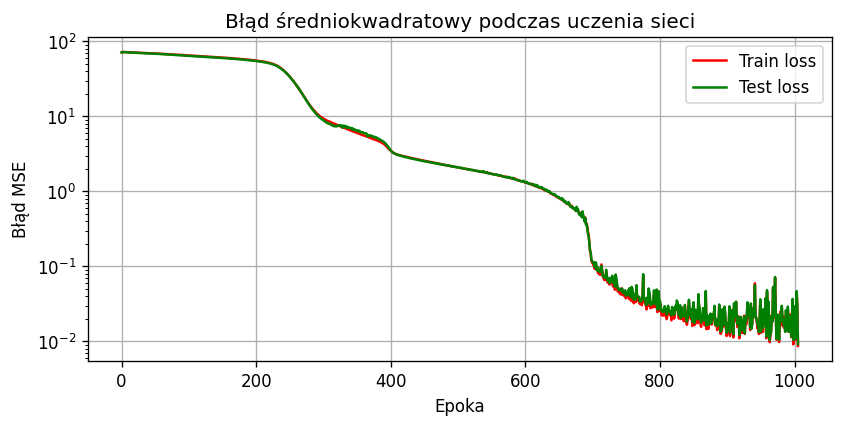

In [35]:
#WIZUALIZACJA BŁĘDU MSE PODCZAS UCZENIA SIECI

plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_error[:], 'r', label='Train loss')
plt.plot(test_error[:], 'g', label='Test loss')
plt.yscale('log')
plt.title('Błąd średniokwadratowy podczas uczenia sieci')
plt.xlabel("Epoka") 
plt.ylabel("Błąd MSE")
plt.grid()
plt.legend() 
plt.show()

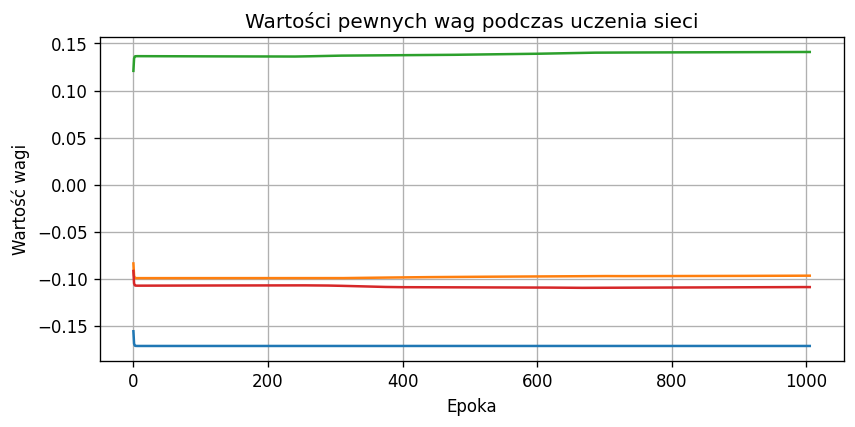

In [36]:
#WIZUALIZACJA ZMIAN WYBRANYCH WAG PODCZAS UCZENIA SIECI

plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(w1[:])
plt.plot(w2[:])
plt.plot(w3[:])
plt.plot(w4[:])
plt.title('Wartości pewnych wag podczas uczenia sieci')
plt.xlabel("Epoka") 
plt.ylabel("Wartość wagi")
plt.grid()
plt.show()

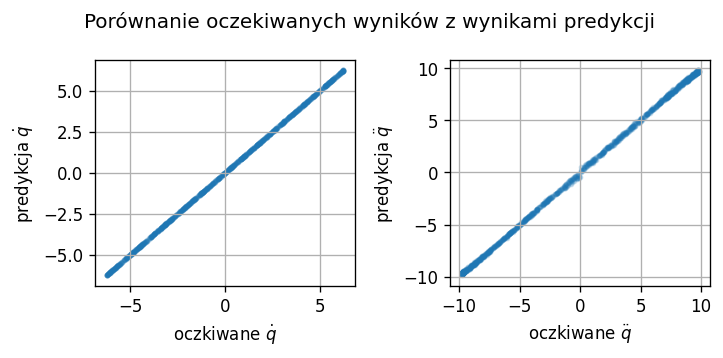

In [37]:
#TEST PREDYKCJI SIECI

#Obliczenie predykcji sieci (wartość wyjściowa) na podstawie zbioru testowego
y_pred = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(x_test)

#Wizualizacji wyników
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120)
fig.suptitle("Porównanie oczekiwanych wyników z wynikami predykcji")
axes[0].scatter(y_test[:, 0], y_pred[:, 0], s=6, alpha=0.2)
axes[0].set_xlabel('oczkiwane $\dot q$')
axes[0].set_ylabel('predykcja $\dot q$')
axes[0].grid()
axes[1].scatter(y_test[:, 1], y_pred[:, 1], s=6, alpha=0.2)
axes[1].set_xlabel('oczkiwane $\ddot q$')
axes[1].set_ylabel('predykcja $\ddot q$')
axes[1].grid()
plt.tight_layout()



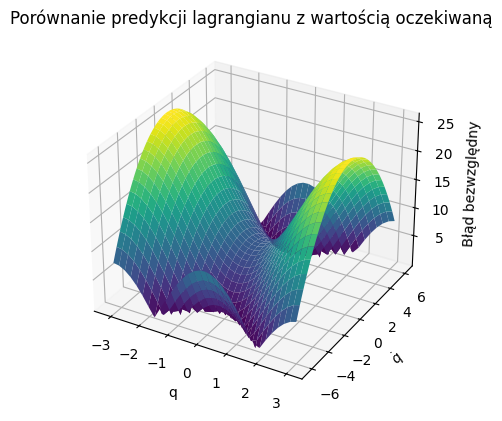

In [38]:
#PORÓWNANIE WARTOŚCI LAGRANGIANU RZCZYWISTEGO I ESTYMACJI

q=jnp.arange(-1*np.pi, np.pi, 0.2, dtype=jnp.float32)
q_t=jnp.arange(-1*v_max, v_max, 0.2, dtype=jnp.float32)

Lagrangian_error = np.zeros([len(q), len(q_t)],dtype=jnp.float32)

for i in range (len(q)):
    for j in range(len(q_t)):
        Lagrangian_true = jax.device_get(lagrangian_analitical(q[i], q_t[j], 1, 1, 9.8)).item()    #Wartość rzczywista
        Lagrangian_pred = jax.device_get(learned_lagrangian(params)(jnp.array([q[i]]), jnp.array([q_t[j]])))   #Predykcja
        Lagrangian_error[i,j] = np.abs(Lagrangian_true-Lagrangian_pred)                             #Błąd (wartość bezwlędna z różnicy)
    
q, q_t = np.meshgrid(q, q_t)



#Wizualizacja
#%matplotlib qt5
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
Lagrangian_error = np.transpose(Lagrangian_error)

axes.set_title("Porównanie predykcji lagrangianu z wartością oczekiwaną")
axes.set_xlabel('q')
axes.set_ylabel('$\dot q$')
axes.set_zlabel("Błąd bezwzględny")
axes.grid()

axes.plot_surface(q, q_t, Lagrangian_error, cmap='viridis')
plt.show()
%matplotlib inline

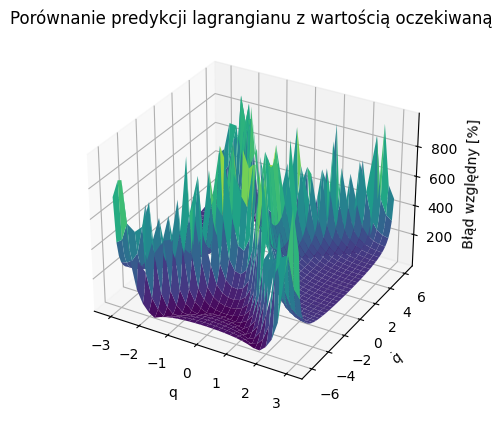

In [39]:
q=jnp.arange(-1*np.pi, np.pi, 0.2, dtype=jnp.float32)
q_t=jnp.arange(-1*v_max, v_max, 0.2, dtype=jnp.float32)

Lagrangian_error = np.zeros([len(q), len(q_t)],dtype=jnp.float32)

for i in range (len(q)):
    for j in range(len(q_t)):
        Lagrangian_true = jax.device_get(lagrangian_analitical(q[i], q_t[j], 1, 1, 9.8)).item()    #Wartość rzczywista
        Lagrangian_pred = jax.device_get(learned_lagrangian(params)(jnp.array([q[i]]), jnp.array([q_t[j]])))   #Predykcja
        if(np.abs(Lagrangian_true)>0.1):
            Lagrangian_error[i,j] = np.abs(Lagrangian_true-Lagrangian_pred)/np.abs(Lagrangian_true)*100             #Błąd (wartość bezwlędna z różnicy)
        else:
            Lagrangian_error[i,j] = float('nan')

q, q_t = np.meshgrid(q, q_t)

Lagrangian_error = np.where(Lagrangian_error >1000, float('nan'), Lagrangian_error)

#Wizualizacja
#%matplotlib qt5
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
Lagrangian_error = np.transpose(Lagrangian_error)

axes.set_title("Porównanie predykcji lagrangianu z wartością oczekiwaną")
axes.set_xlabel('q')
axes.set_ylabel('$\dot q$')
axes.set_zlabel("Błąd względny [%]")
axes.grid()

axes.plot_surface(q, q_t, Lagrangian_error, cmap='viridis')
plt.show()
%matplotlib inline

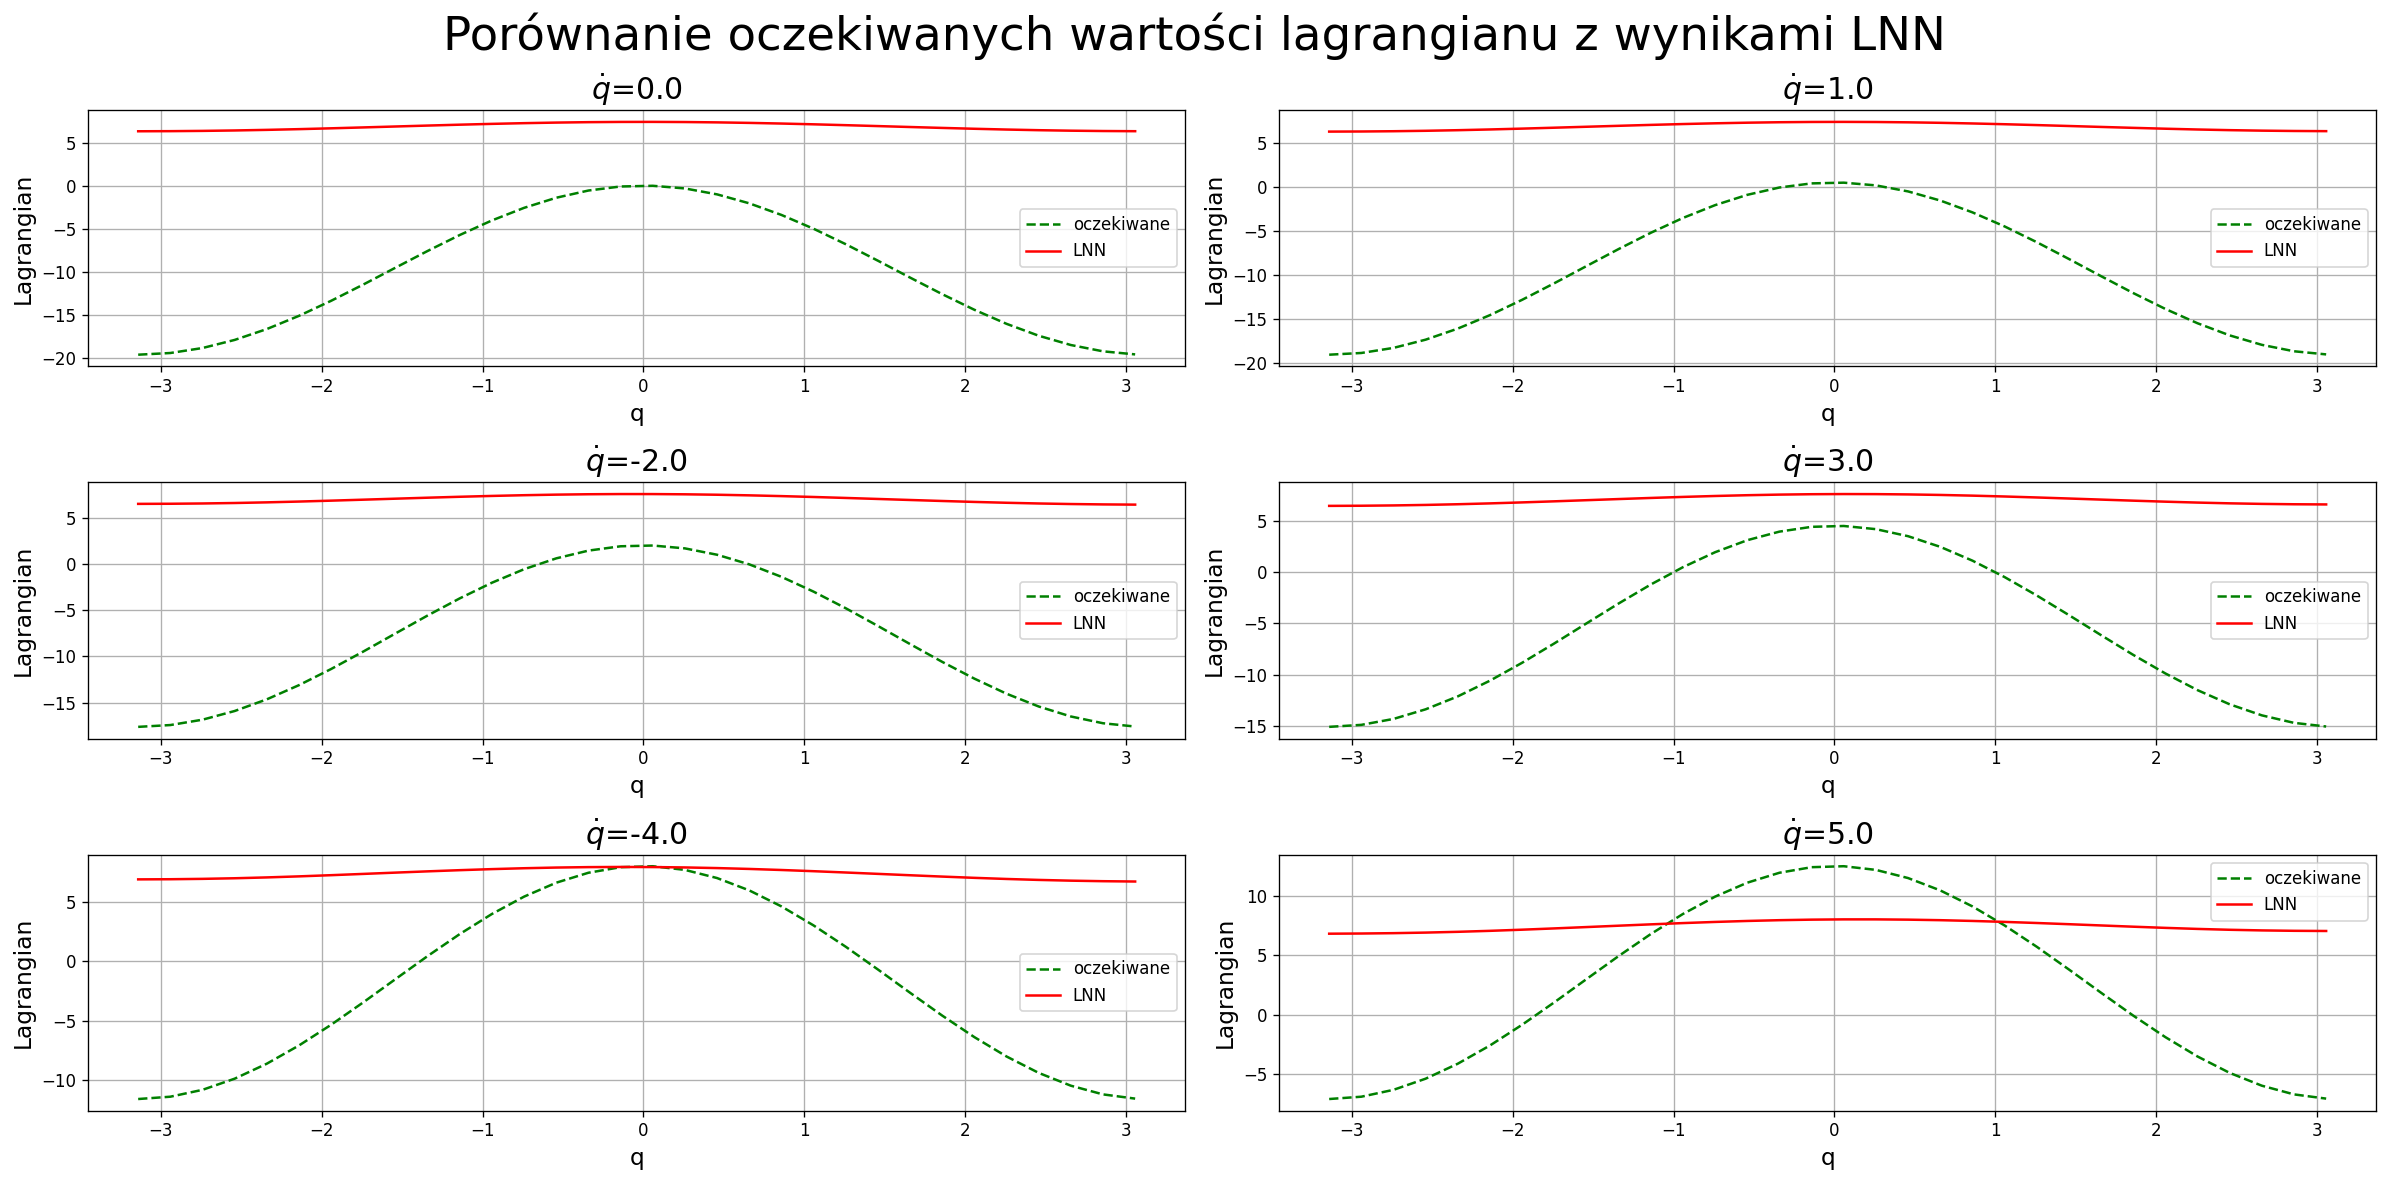

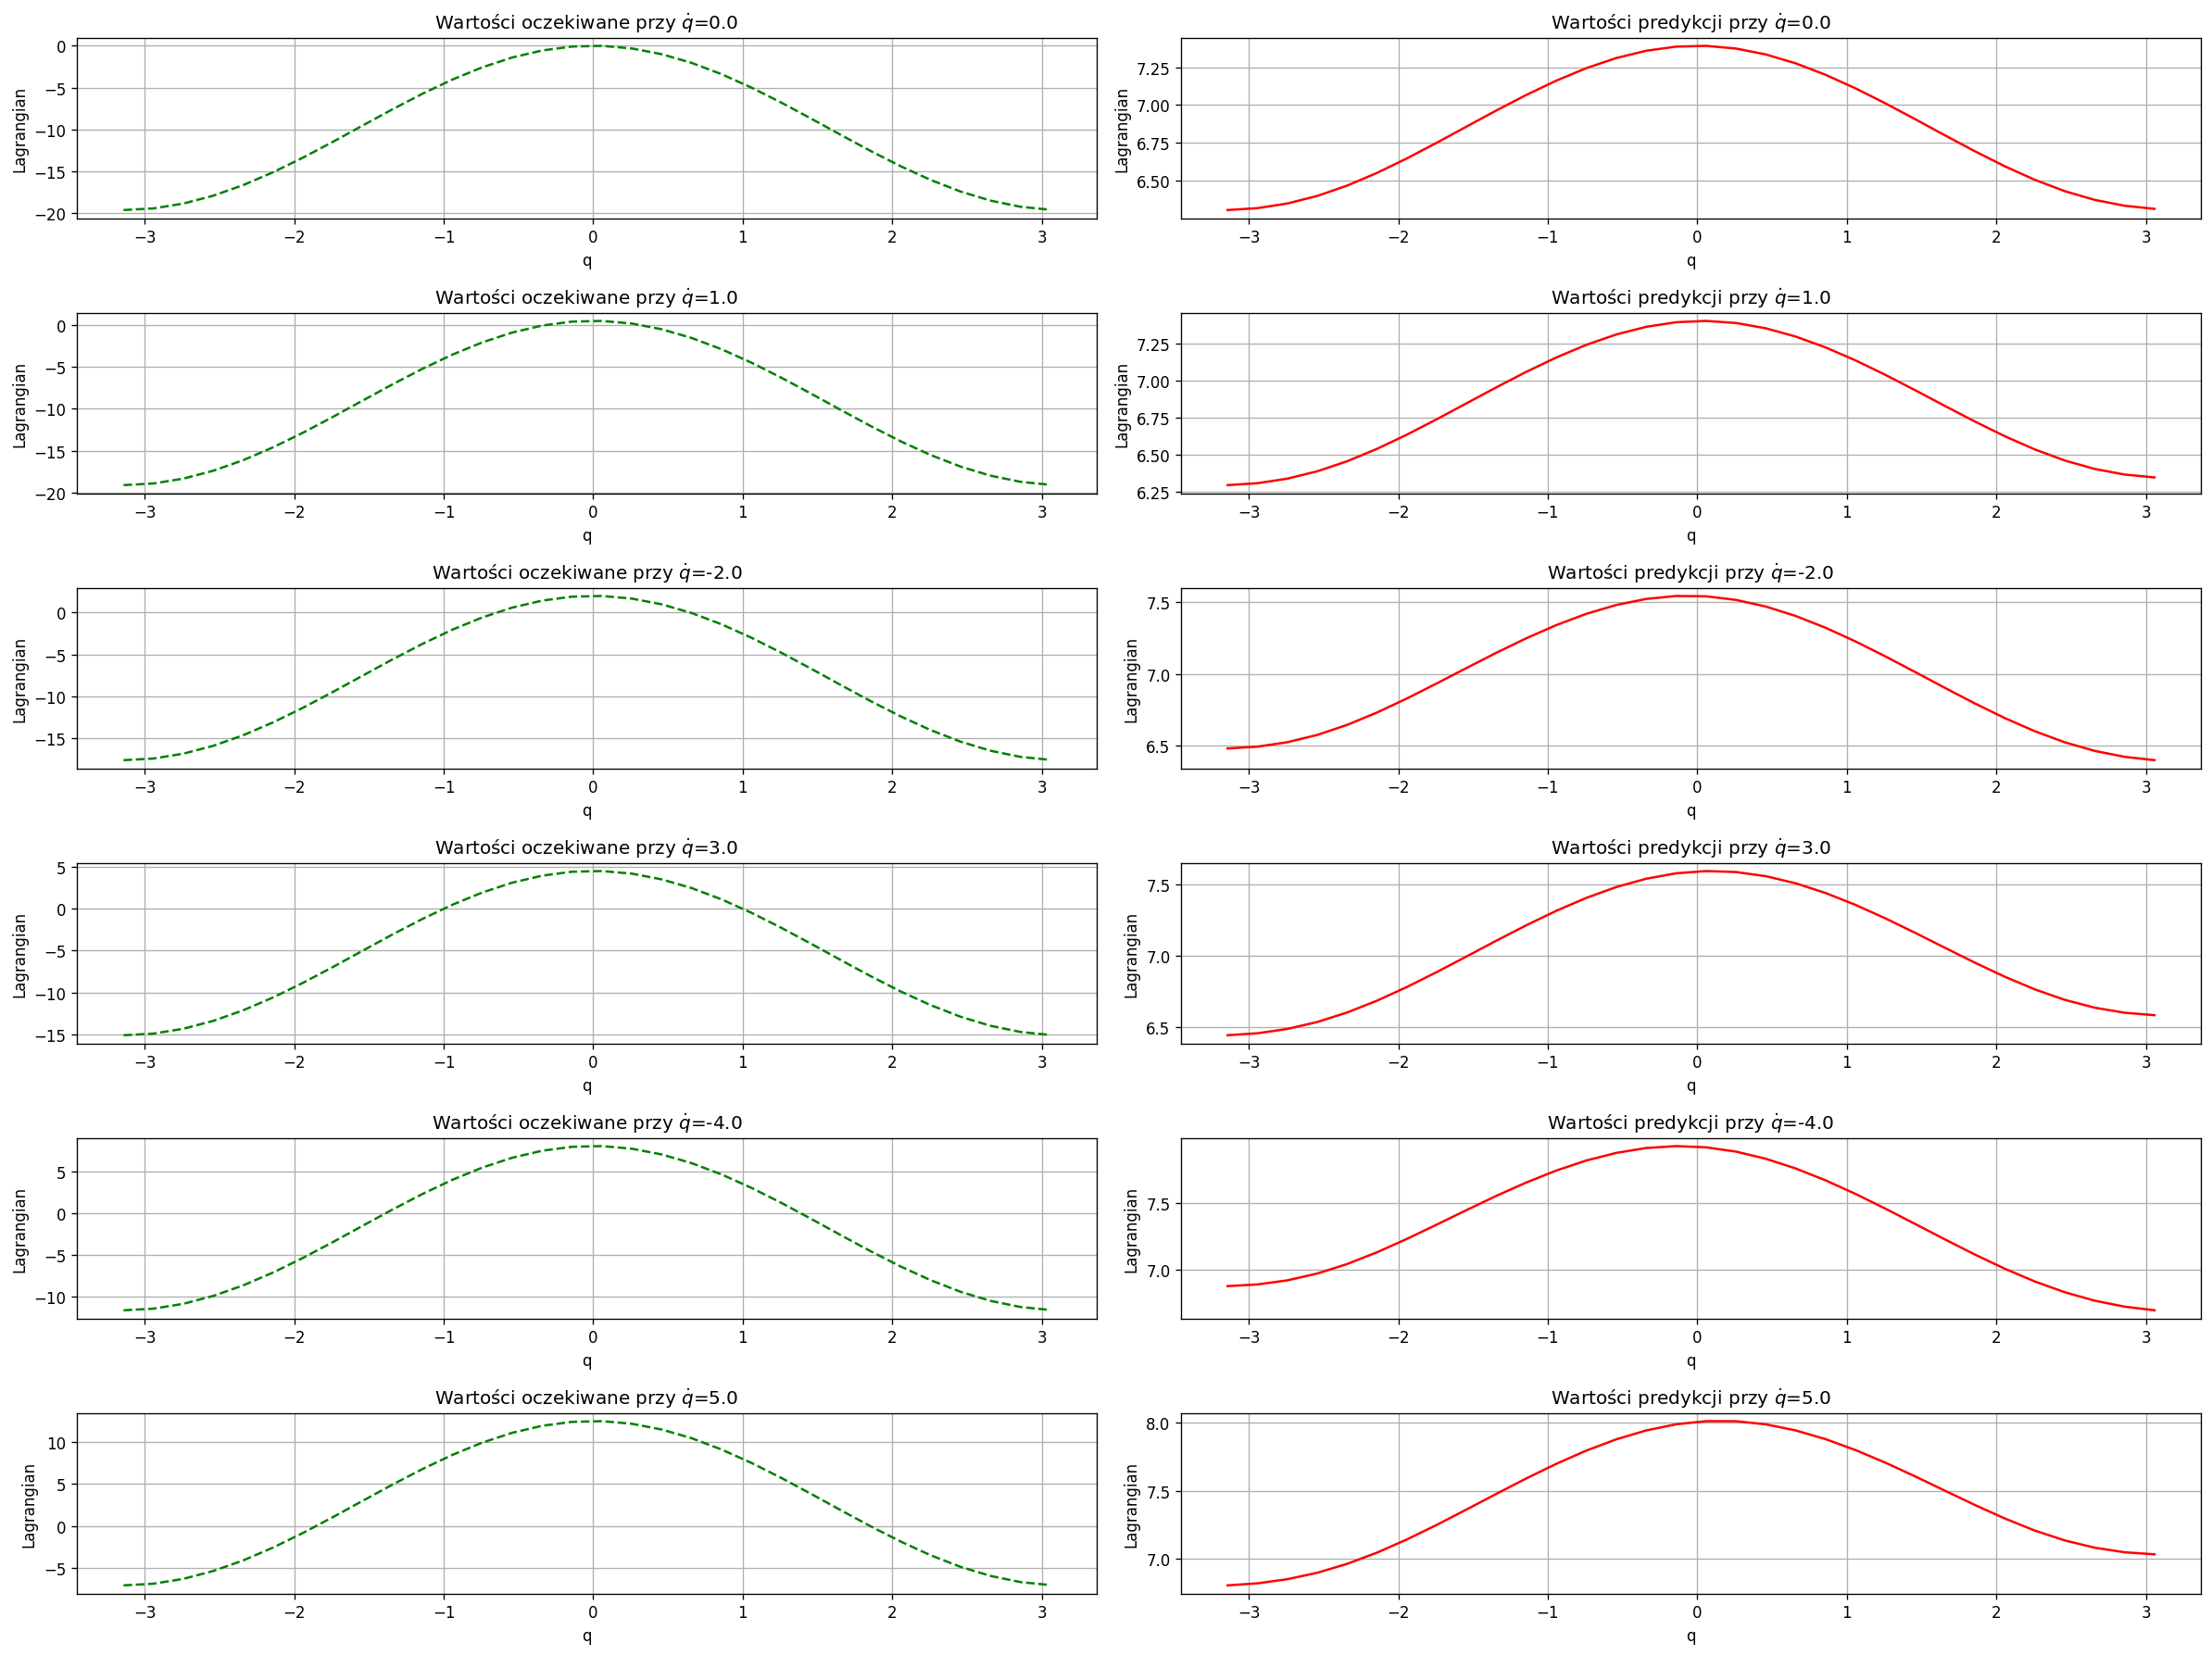

In [40]:
q=jnp.arange(-1*np.pi, np.pi, 0.2, dtype=jnp.float32)
q_t=jnp.array([0,1,-2,3,-4,5], dtype=jnp.float32)


Lagrangian_true = np.zeros([len(q), len(q_t)],dtype=jnp.float32)
Lagrangian_pred = np.zeros([len(q), len(q_t)],dtype=jnp.float32)

for i in range (len(q)):
    for j in range(len(q_t)):
        Lagrangian_true[i,j] = jax.device_get(lagrangian_analitical(q[i], q_t[j], 1, 1, 9.8)).item()                #Wartość rzeczywista
        Lagrangian_pred[i,j] = jax.device_get(learned_lagrangian(params)(jnp.array([q[i]]), jnp.array([q_t[j]])))   #Predykcja




#WIZUALIZACJA
fig, axes = plt.subplots(3, 2, figsize=(20, 10), dpi=120)
for i, ax in enumerate(axes.flat):
    ax.plot(q, Lagrangian_true[:, i], 'g--', label='oczekiwane')
    ax.plot(q, Lagrangian_pred[:, i], 'r', label='LNN')
    ax.set_xlabel('q', fontsize=14)
    ax.set_ylabel('Lagrangian', fontsize=14)
    ax.set_title('$\dot q$='+str(q_t[i]), fontsize=18)
    ax.legend()
    ax.grid()
    
    
fig.suptitle('Porównanie oczekiwanych wartości lagrangianu z wynikami LNN', fontsize=28)


plt.tight_layout()


#Wizualizacji wyników
fig1, axes1 = plt.subplots(6, 2, figsize=(20, 15), dpi=120)

for i in range(len(q_t)):
    axes1[i,0].plot(q, Lagrangian_true[:, i],'g--')
    axes1[i,0].set_ylabel('Lagrangian')
    axes1[i,0].set_xlabel('q')
    axes1[i,0].set_title('Wartości oczekiwane przy $\dot q$='+str(q_t[i]))
    axes1[i,0].grid()
    axes1[i,1].plot(q, Lagrangian_pred[:, i],'r')
    axes1[i,1].set_ylabel('Lagrangian')
    axes1[i,1].set_xlabel('q')
    axes1[i,1].set_title('Wartości predykcji przy $\dot q$='+str(q_t[i]))
    axes1[i,1].grid()
plt.tight_layout()







In [41]:

#Funkcja wyznaczająca trajektorię ruchu przy użyciu Lagrangianu zamodlowanego za pomocą sieci neuronowej
#Argumenty funkcji:
#   -params        - Parametry sieci neuronowej
#   -initial_state - Początkowego położenie oraz prędkości
#   -times         - Czas wyznaczanej trajektori
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
@partial(jax.jit, backend='cpu')
def solve_lagrangian(params, initial_state, times):
  return odeint(partial(equation_of_motion, learned_lagrangian(params)),
                  initial_state, times, rtol=1e-10, atol=1e-10)


CPU times: user 2.46 s, sys: 184 ms, total: 2.64 s
Wall time: 2.64 s
CPU times: user 1.33 ms, sys: 238 µs, total: 1.57 ms
Wall time: 2.7 ms


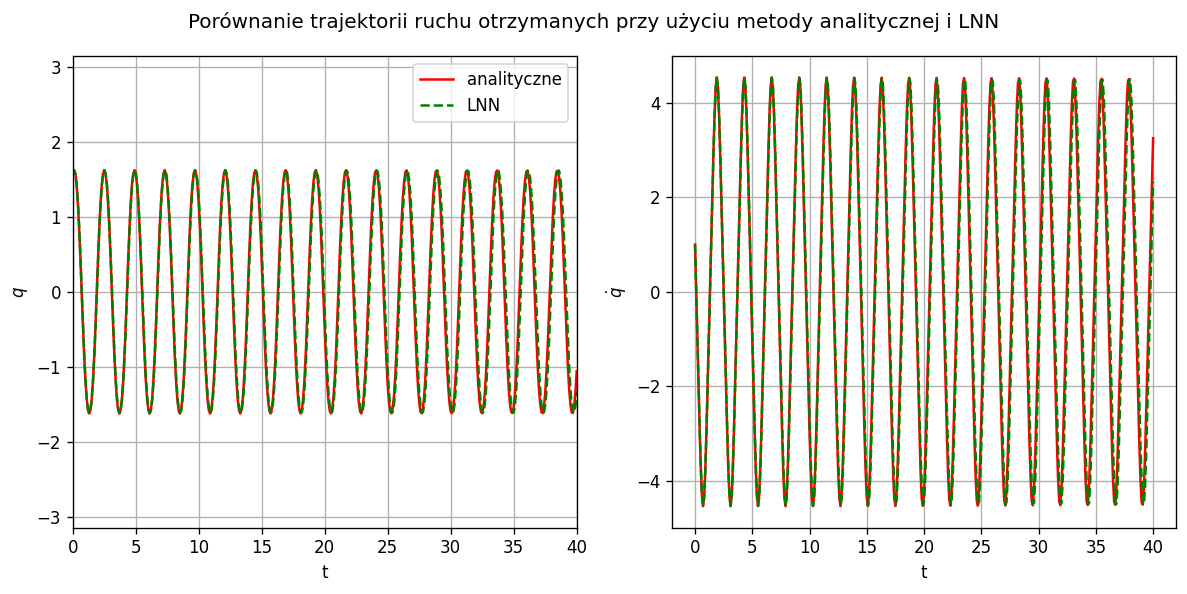

In [42]:
#TEST WYZNACZENIA TRAJEKTORI RUCHU PRZY UŻYCIU SIECI NEURONOWEJ

#Punkt startowy
x0 = jnp.array([np.pi/2,1], dtype=np.float32)
#Wektor czasu
t = np.linspace(0, 40, num=401, dtype=np.float32)

#Wyznaczenie trajektori przy użyciu sieci
%time lagrangian_trajectory = jax.device_get(solve_lagrangian(params, x0, t))
lagrangian_trajectory = jax.device_get(jax.vmap(normalize)(lagrangian_trajectory))

#Wyznaczenie trajektori metodą analityczną
%time analitical_trajectory = jax.device_get(solve_analitical(x0, t))


#WIZUALIZACJA
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Porównanie trajektorii ruchu otrzymanych przy użyciu metody analitycznej i LNN')


axes[0].plot(t, analitical_trajectory[:, 0], 'r', label='analityczne')
axes[0].plot(t, lagrangian_trajectory[:, 0], 'g--', label='LNN')
axes[0].set_xlabel('t')
axes[0].set_ylabel('$q$')
axes[0].legend()
axes[0].grid()
axes[0].axis([0,t[-1],-1*np.pi,np.pi])


axes[1].plot(t, analitical_trajectory[:, 1], 'r', label='analityczne')
axes[1].plot(t, lagrangian_trajectory[:, 1], 'g--', label='LNN')
axes[1].set_xlabel('t')
axes[1].set_ylabel('$\dot q$')
axes[1].grid()

plt.tight_layout()

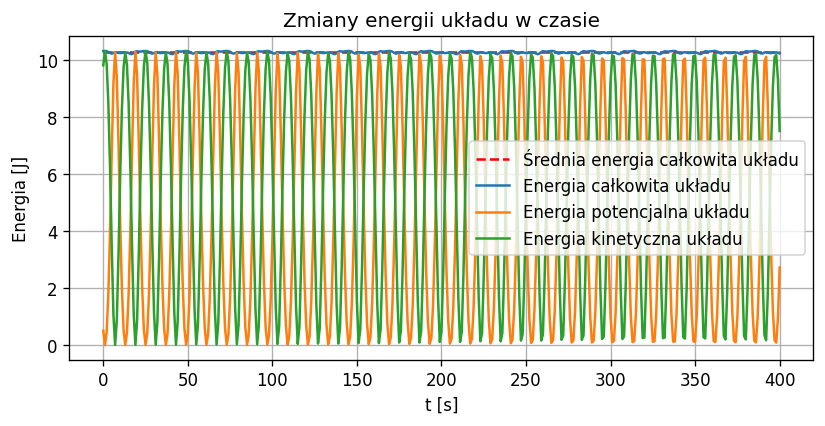

In [43]:
#Wyznaczenie Energi potencjalnej i kinetycznej trajektorii

q, q_t = jnp.hsplit(lagrangian_trajectory, 2)
energy = partial(compute_energy, m=1, l=1, g=9.81)
Ep, Ek = jax.vmap(energy)(q, q_t)
Ec=Ep+Ek
mean = jnp.mean(Ec)
mean_Ec = jnp.ones(Ec.shape, dtype=jnp.float32) * jnp.mean(Ec)

plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(mean_Ec, 'r--', label="Średnia energia całkowita układu")
plt.plot(Ec, label="Energia całkowita układu")
plt.plot(Ep, label="Energia potencjalna układu")
plt.plot(Ek, label="Energia kinetyczna układu")
plt.title('Zmiany energii układu w czasie')
plt.xlabel("t [s]") 
plt.ylabel("Energia [J]")
plt.legend()
plt.grid()
plt.show()